## Preprocessing and EDA 

### Load

In [21]:
import os
from dotenv import load_dotenv
import pandas as pd
from twarc import Twarc2, expansions
from tweet_processing import StreamTweetProcessor

import matplotlib.pyplot as plt
import numpy as np

In [229]:
load_dotenv()

data_dir="../stream-seeding/data" 
twarc_client = Twarc2(
    consumer_key=os.environ["consumer_key"], 
    consumer_secret=os.environ["consumer_secret"],
    access_token=os.environ["access_token"], 
    access_token_secret=os.environ["access_token_secret"]
)

tp = StreamTweetProcessor(twarc_client=twarc_client, data_dir=data_dir)

groups = ["longevity-pranab", "CA-Abundance-Economy"]
following, tweets, refs  = [], [], []
dfs = [following, tweets, refs]

for g in groups: 
    [f, t, r] = tp.load_stream_seed_data(g)
    refs.append(r), tweets.append(t) , following.append(f)

dfs = [pd.concat(df) for df in dfs]
df_following, df_tweets, df_refs = dfs

/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_60479/2303052575.py:18: DtypeWarning: Columns (45,46,55,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  [f, t, r] = tp.load_stream_seed_data(g)


### Peek

In [237]:
df_tweets = df_tweets[['id', 'text', 'author_id', 'author.username', 'created_at', 'public_metrics.like_count', 'public_metrics.quote_count', 'public_metrics.reply_count', 'public_metrics.retweet_count','attachments.media','attachments.media_keys']]
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])

# ensure consistency in id/name
assert df_tweets.author_id.value_counts().to_list() ==  df_tweets["author.username"].value_counts().to_list()
df_tweets.dropna().head()

,id,text,author_id,author.username,created_at,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,attachments.media,attachments.media_keys
49,1491586455268827137,One of my favorite things to do is pretend I'm...,301427990,LauraDeming,2022-02-10 01:34:57+00:00,128,0,9,9,"[{""media_key"": ""3_1491574214108717059"", ""type""...","[""3_1491574214108717059""]"
70,1481617637801136136,The Italians in 1545 were *really* excited abo...,301427990,LauraDeming,2022-01-13 13:22:26+00:00,372,3,15,30,"[{""type"": ""photo"", ""url"": ""https://pbs.twimg.c...","[""3_1481617594562007043""]"
72,1479586908900663307,I liked this - poetry should induce a physical...,301427990,LauraDeming,2022-01-07 22:53:03+00:00,46,1,4,4,"[{""type"": ""photo"", ""url"": ""https://pbs.twimg.c...","[""3_1479586425582624768""]"
76,1476555253755568132,Fun puzzle: stare at the abundance of elements...,301427990,LauraDeming,2021-12-30 14:06:20+00:00,43,0,6,3,"[{""media_key"": ""3_1476555103398244353"", ""heigh...","[""3_1476555103398244353""]"
83,1475575388386603013,One bio experiment I love is slowing down temp...,301427990,LauraDeming,2021-12-27 21:12:42+00:00,168,1,16,7,"[{""url"": ""https://pbs.twimg.com/media/FHpLvUjX...","[""3_1475575104260259841""]"


In [238]:
# Counting "pure" tweets
# TODO: include retweets, urls
# TODO: use df_tweets.entities.mentions.usernames to exemot from preprocessing

n = df_tweets['attachments.media'].isna().sum()/df_tweets.shape[0]
print(f"Percentage of tweets without media: {n:.2%}")

Percentage of tweets without media: 87.46%


In [239]:
# Get tweets from 301427990
authors = df_tweets['author.username'].value_counts().to_dict()

for author in authors.keys():
    authors[author] = df_tweets[df_tweets['author.username'] == author].index.to_list()

# Preprocessing

In [240]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tweets = df_tweets.text.values

len(tweets), tweets[:3]

(17550,
 array(["I'd like to have fluency with basic game theory well enough to have intuition for the situations presented in Parfit's 'Reasons and Persons'. Any suggestions for a text or tutor?\\n\\nWant to build really strong, simple intuitions to go with the relevant equations - nothing fancy.",
        'I wish there was a Serious Eats but for bio protocols.',
        "Half of it reads like a modern Medium post, the other half contains such wisdom as\\n\\n'You should not buy a donkey which brays; it will split (?) your midriff (?).'\\n\\n'You should not pass judgment when you drink beer.'\\n\\n'Fate is a wet bank; it can make one slip.'"],
       dtype=object))

In [241]:
import re

def preprocess(text):
    text = text.lower()
    # replace first \n with space
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\\n', ' ', text)
    
    # remove unicode characters, except @ and #
    text = re.sub(r'[^\x00-\x7f]',r' ', text)

    return text

t = 3
preprocess(tweets[t]), tweets[t]

("thanks @michael_nielsen for pointing out that many of the first books in history were generic self-help advice pieces, and that i was thus joining a long and venerable tradition.  although i'm not sure one can beat gems from 'instructions of shuruppag'. ",
 "Thanks @michael_nielsen for pointing out that many of the first books in history were generic self-help advice pieces, and that I was thus joining a long and venerable tradition.\\n\\nAlthough I'm not sure one can beat gems from 'instructions of Shuruppag'.\\nhttps://t.co/e5Wacy1AIz")

In [244]:
# Tokenize tweets
# TODO: investigate nltk vs inbuilt stop_words
# TODO: don't remove @mentions :: named entity recog?

vectorizer = CountVectorizer(strip_accents = 'unicode', stop_words='english', preprocessor=preprocess)
X = vectorizer.fit_transform(tweets)

# tfidf on tweets
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words='english', preprocessor=preprocess)
tfidf = tfidf_vectorizer.fit_transform(tweets)

tfidf.shape, X.shape

((17550, 27051), (17550, 27051))

In [525]:
# How similar are tweets from same author
author_docs = dict.fromkeys(authors.keys(), [])

for author in authors.keys():
    # Sum counts over all tweets
    mat = tfidf[authors[author], :].sum(axis=0)
    author_docs[author] = np.squeeze(np.asarray(mat))

In [409]:
# measure distance between tweets
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

docs = np.vstack(list(author_docs.values()))

# similarity matrices
cosine = cosine_similarity(docs)
euclidean = euclidean_distances(docs)

In [410]:
def most_similar(author :int, sim_mat: np.array, n=2):
    # return most similar author
    i = list(author_docs.keys()).index(author)
    
    v = sim_mat[i, :]

    measure = f'{sim_mat=}'.split('=')[0]
    if measure == 'cosine':
        v = np.argsort(v)[::-1]
    else:
        v = np.argsort(v)

    auth_idxs = v[1:n+1]
    auths = [list(author_docs.keys())[i] for i in auth_idxs]
    
    return auths

long_users = ['celinehalioua', 'ArtirKel', 'LauraDeming']
ca_users = ['anniefryman', 'rklau', 'hanlonbt' ]

most_similar('LauraDeming', euclidean)

['hanlonbt', 'rklau']

In [411]:
def completion_accuracy(source_acc: str, recs: list):
    # source_acc = account to recommend from
    # recs = list of recommended accounts
    # returns number of TP

    if source_acc in long_users:
        target_set = set(long_users)
    elif source_acc in ca_users:
        target_set = set(ca_users)
    else:
        raise ValueError("source_acc not in any set")
    
    tp = len(set(recs).intersection(target_set))
    return tp

completion_accuracy('LauraDeming', most_similar('LauraDeming', euclidean))

0

Probability of getting 2/2 correct
    2/2 correct = 1/5 * 1/4 = 1/20
Probability of getting 1/2 correct
    1/2 correct = 4/5 * 1/4 + 1/5 * 3/4 = 7/20

**Accuracy of random assignment = 1/20 + 7/20 = 40%.**

In [522]:
from math import perm
from itertools import permutations

# Generalises to n authors
def random_acc(n_authors: int, n_recs: int) -> float:
    # Return accuracy of random assignment

    # Total authors to recommend from, exempting source
    n = n_authors - 1
    # Number of recommendations to make
    r = n_recs

    # i is number of true positives
    p_0 = 0
    for i in range(1, r+1):

        base_arr = np.zeros(r)
        base_arr[:i] = 1

        perms = list(set(permutations(base_arr, r)))

        p_1 = 0
        for permutation in perms: 
            p_2 = 1
            for idx,p in enumerate(permutation):
                if p == 1:
                    p_2 *= 1/(n-idx)
                elif p == 0:
                    p_2 *= (n-idx-1)/(n-idx)
            p_1 += p_2
        p_0 += p_1

    return p_0

random_acc(6, 2)

0.4

/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_60479/683490241.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  p_2 *= (n-idx-1)/(n-idx)
/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_60479/683490241.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  p_2 *= 1/(n-idx)
/var/folders/6v/v3k0ftn92ld7ss4w20w4t8480000gn/T/ipykernel_60479/683490241.py:27: RuntimeWarning: invalid value encountered in double_scalars
  p_2 *= 1/(n-idx)


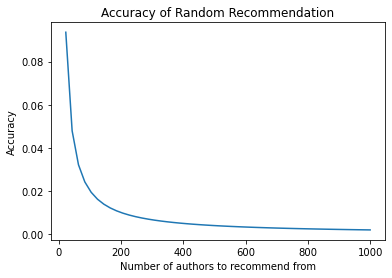

In [529]:
# See how accuracy scales with n
n_authors = np.linspace(2, 1000)
n_recs = 2
accs = [random_acc(n, n_recs) for n in n_authors]

# plot
plt.plot(n_authors, accs)
plt.xlabel('Number of authors to recommend from')
plt.ylabel('Accuracy')
plt.title("Accuracy of Random Recommendation")
plt.show()

In [527]:
n_rec = 3

tp = 0
rand_p = 0
accounts = long_users + ca_users

for acc in accounts:
    n_acc = len(accounts)

    recs = most_similar(acc, cosine, n=n_rec)
    hits = completion_accuracy(acc, recs)

    rand_recs = [accounts[i] for i in np.random.choice(n_acc, n_rec, replace=False)]
    while acc in rand_recs:
        rand_recs = [accounts[i] for i in np.random.choice(n_acc, n_rec, replace=False)]
    rand_hits = completion_accuracy(acc, rand_recs)
    
    print(f"Similarity  | {acc} -> {recs} : {hits}")
    print(f"Random      | {acc} -> {rand_recs} : {rand_hits} \n")

    tp += hits
    rand_p += rand_hits


accuracy = tp/(2*n_acc)
print(f"Accuracy of Similarity Assignment: {accuracy:.2%}")
print(f"Accuracy of Random Assignment: {random_acc(6,2):.2%}")

Similarity  | celinehalioua -> ['anniefryman', 'LauraDeming', 'rklau'] : 1
Random      | celinehalioua -> ['ArtirKel', 'anniefryman', 'rklau'] : 1 

Similarity  | ArtirKel -> ['LauraDeming', 'hanlonbt', 'anniefryman'] : 1
Random      | ArtirKel -> ['LauraDeming', 'celinehalioua', 'rklau'] : 2 

Similarity  | LauraDeming -> ['anniefryman', 'rklau', 'celinehalioua'] : 1
Random      | LauraDeming -> ['anniefryman', 'rklau', 'ArtirKel'] : 1 

Similarity  | anniefryman -> ['LauraDeming', 'hanlonbt', 'rklau'] : 2
Random      | anniefryman -> ['hanlonbt', 'celinehalioua', 'rklau'] : 2 

Similarity  | rklau -> ['anniefryman', 'hanlonbt', 'celinehalioua'] : 2
Random      | rklau -> ['ArtirKel', 'celinehalioua', 'LauraDeming'] : 0 

Similarity  | hanlonbt -> ['anniefryman', 'rklau', 'LauraDeming'] : 2
Random      | hanlonbt -> ['rklau', 'anniefryman', 'ArtirKel'] : 2 

Accuracy of Similarity Assignment: 75.00%
Accuracy of Random Assignment: 40.00%
